# E2: Unimodal Vision Architectures (Coding)
Welcome to the coding part of the second exercise sheet. You will explore the two most popular architecture families for processing images: Convolutional Neural Networks (ConvNets) and Vision Transformers (ViTs).

The parts you must implement are within the `# ---- YOUR CODE STARTS HERE ----------` and `# ---- YOUR CODE ENDS HERE ----------` lines.

Refer to the PDF handout for the more detailed and precise requirements for each section. If in doubt, follow the instructions from the PDF handout, not the notebook itself.

## 0. Data Preparation (0 pts)

The first code block will download the ImageNette data. This is a subset of the ILSVRC2012 dataset (popularly known as ImageNet), including 10 easy to distinguish classes. (0 pts)

In [ ]:
# --- Install dependencies (if needed in Colab) ---
# !pip install --quiet torch torchvision

import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm

# --- Download Imagenette (320px size) ---
# Reference: https://github.com/fastai/imagenette
IMAGENETTE_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"
DATA_ROOT = "./data"
NUM_EPOCHS = 10

# Mapping from folder name (WordNet ID) to human-readable class name
IMAGENETTE_LABELS = {
    'n01440764': 'tench',
    'n02102040': 'English springer',
    'n02979186': 'cassette player',
    'n03000684': 'chain saw',
    'n03028079': 'church',
    'n03394916': 'French horn',
    'n03417042': 'garbage truck',
    'n03425413': 'gas pump',
    'n03445777': 'golf ball',
    'n03888257': 'parachute'
}

os.makedirs(DATA_ROOT, exist_ok=True)

if not os.path.exists(os.path.join(DATA_ROOT, "imagenette2-320")):
    import tarfile, urllib.request
    print("Downloading Imagenette...")
    urllib.request.urlretrieve(IMAGENETTE_URL, os.path.join(DATA_ROOT, "imagenette2-320.tgz"))
    print("Extracting...")
    with tarfile.open(os.path.join(DATA_ROOT, "imagenette2-320.tgz"), "r:gz") as tar:
        tar.extractall(DATA_ROOT)
    print("Done!")

DATA_DIR = os.path.join(DATA_ROOT, "imagenette2-320")

# --- Set up data transforms ---
# For demo, normalizing with ImageNet stats
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

test_transform = transforms.Compose([
    transforms.Resize(236),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

TRAIN_DIR = os.path.join(DATA_DIR, "train")

full_train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)

# Let's split 90% train / 10% validation
train_len = int(0.9 * len(full_train_dataset))
val_len = len(full_train_dataset) - train_len
original_train_dataset, original_val_dataset = random_split(
  full_train_dataset, [train_len, val_len],
  generator=torch.Generator().manual_seed(42)  # For reproducibility!
)

def get_loaders(train_transform, test_transform, batch_size=256):
    # re-apply appropriate transform to val_dataset
    train_dataset = torch.utils.data.Subset(
      datasets.ImageFolder(TRAIN_DIR, transform=train_transform),
      original_train_dataset.indices
    )
    # re-apply appropriate transform to val_dataset
    val_dataset = torch.utils.data.Subset(
      datasets.ImageFolder(TRAIN_DIR, transform=test_transform),
      original_val_dataset.indices
    )


    # --- Sample inspection: print sizes ---
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")
    print(f"Classes: {[IMAGENETTE_LABELS[c] for c in full_train_dataset.classes]}")

    # --- Set up DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader

train_loader, val_loader = get_loaders(train_transform, test_transform)

Extracting...
Done!
Train: 8522, Val: 947
Classes: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


In [ ]:
def train(
        model, trainloader, valloader, device=None,
        optimizer=None, criterion=None, scheduler=None,
        num_epochs=10
    ):

    # setup
    def_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
    optimizer = optimizer or def_optimizer

    def_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    scheduler = scheduler or def_scheduler
    criterion = criterion or def_criterion

    model = model.to(device)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in tqdm.tqdm(range(num_epochs)):
        # -- Train
        model.train()
        train_loss = train_acc = t_total = 0
        for xb, yb in trainloader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            train_acc  += accuracy(out, yb) * xb.size(0)
            t_total += xb.size(0)
        train_loss /= t_total
        train_acc  /= t_total

        # -- Val
        model.eval()
        val_loss = val_acc = v_total = 0
        with torch.no_grad():
            for xb, yb in valloader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item() * xb.size(0)
                val_acc  += accuracy(out, yb) * xb.size(0)
                v_total += xb.size(0)
        val_loss /= v_total
        val_acc  /= v_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1:02}/{num_epochs} - "
              f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")
        scheduler.step()

    # --- PLOTS ---
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def accuracy(outputs, labels):
    preds = outputs.argmax(dim=1)
    return (preds == labels).float().mean().item()
device = torch.device('cuda:0')

## 1. ConvNet (7 pts)

### 1.a) ConvNet Implementation

Implement a multi-layer Convolutional Neural Network (ConvNet). Specifically, we will work with a small ResNet model. The class is mostly already provided except for some indicated parts. You must implement these. Follow the original ResNet paper.

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1  # Output channels multiplier

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.downsample = downsample
        # ---- YOUR CODE STARTS HERE ---------- # no further Conv2d modules are needed
        self.batch1 = nn.BatchNorm2d(planes)
        self.batch2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        # ---- YOUR CODE ENDS HERE ----------

    def forward(self, x):
        # ---- YOUR CODE STARTS HERE ----------
        # "We adopt batch normalization (BN) right after each convolution and before activation"
        conv1_out = self.conv1(x)
        batch1_out = self.batch1(conv1_out)
        relu1_out = self.relu(batch1_out)
        conv2_out = self.conv2(relu1_out)
        batch2_out = self.batch2(conv2_out)

        if self.downsample is not None: #Falls die ConvLayer zum Beispiel durch Stride den Output kleiner gemacht haben, muss x für residual conection gedownsapled werden
            x = self.downsample(x)

        rc_out = batch2_out + x
        out = self.relu(rc_out)
        # ---- YOUR CODE ENDS HERE ----------
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.base_in_planes = 32
        self.in_planes = self.base_in_planes
        self.conv1 = nn.Conv2d(3, self.base_in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.base_in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, self.base_in_planes,  layers[0])
        self.layer2 = self._make_layer(block, self.base_in_planes*2, layers[1], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.layer3 = self._make_layer(block, self.base_in_planes*4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, self.base_in_planes*8, layers[3], stride=2)
        self.fc = nn.Linear(self.base_in_planes*8 * block.expansion, num_classes)



        # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = [block(self.in_planes, planes, stride, downsample)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(num_classes=10):
    # ResNet-18 = [2, 2, 2, 2] blocks per layer
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

### 1.b) ConvNet training

#### 1.b)i. Train and evaluate

Training and evaluation code is also provided. You should run the training, which
will output loss and accuracy curves on the training and validation sets. Train and validate your ResNet.

Number of parameters in your ResNet-18: 2,801,450


 10%|█         | 1/10 [00:35<05:16, 35.13s/it]

Epoch 01/10 - Train loss: 1.9123, acc: 0.3805 | Val loss: 1.8596, acc: 0.4456


 20%|██        | 2/10 [01:07<04:26, 33.36s/it]

Epoch 02/10 - Train loss: 1.6237, acc: 0.5177 | Val loss: 1.6208, acc: 0.5312


 30%|███       | 3/10 [01:40<03:52, 33.26s/it]

Epoch 03/10 - Train loss: 1.4861, acc: 0.5800 | Val loss: 1.6101, acc: 0.5554


 40%|████      | 4/10 [02:12<03:16, 32.77s/it]

Epoch 04/10 - Train loss: 1.4181, acc: 0.6215 | Val loss: 1.5532, acc: 0.5829


 50%|█████     | 5/10 [02:45<02:44, 32.85s/it]

Epoch 05/10 - Train loss: 1.3421, acc: 0.6462 | Val loss: 1.2311, acc: 0.7138


 60%|██████    | 6/10 [03:18<02:12, 33.05s/it]

Epoch 06/10 - Train loss: 1.2809, acc: 0.6712 | Val loss: 1.1720, acc: 0.7212


 70%|███████   | 7/10 [03:51<01:39, 33.04s/it]

Epoch 07/10 - Train loss: 1.2256, acc: 0.6947 | Val loss: 1.1259, acc: 0.7582


 80%|████████  | 8/10 [04:24<01:05, 32.80s/it]

Epoch 08/10 - Train loss: 1.1963, acc: 0.7166 | Val loss: 1.0948, acc: 0.7666


 90%|█████████ | 9/10 [04:57<00:32, 32.92s/it]

Epoch 09/10 - Train loss: 1.1629, acc: 0.7231 | Val loss: 1.0419, acc: 0.7951


100%|██████████| 10/10 [05:29<00:00, 32.98s/it]

Epoch 10/10 - Train loss: 1.1416, acc: 0.7388 | Val loss: 1.0371, acc: 0.8015


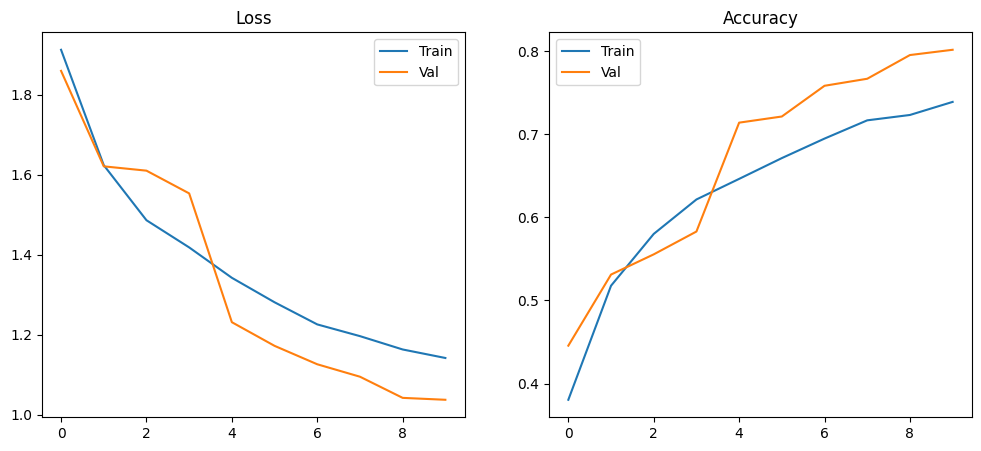

In [ ]:
resnet_model = resnet18(num_classes=len(train_loader.dataset.dataset.classes)).to(device)
print(f"Number of parameters in your ResNet-18: {count_parameters(resnet_model):,}")

train(resnet_model, train_loader, val_loader, device, num_epochs=NUM_EPOCHS)

#### 1.b)ii. Fix the evaluation

You might observe that the training accuracy and loss are worse than or very close to those for validation.

Correct the mistakes of the current evaluation that you observe.

In [ ]:
from xml.etree.ElementTree import TreeBuilder
def evaluate(model, loader, device):
    model.eval()
    total_loss, total_acc, total_items = 0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = nn.functional.cross_entropy(logits, yb)
            pred = logits.argmax(dim=1)
            acc = (pred == yb).float().sum().item()
            total_loss += loss.item() * xb.size(0)
            total_acc += acc
            total_items += xb.size(0)
    return total_loss / total_items, total_acc / total_items

train_loss_wrong, train_acc_wrong = evaluate(resnet_model, train_loader, device)


# ---- YOUR CODE STARTS HERE ----------
#train_loader wird so erstellt:

#train_dataset = torch.utils.data.Subset(
#  datasets.ImageFolder(TRAIN_DIR, transform=train_transform),
#  original_train_dataset.indices
#  )
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

#Problem: train_loader wird zu evaluation genutzt. Die Daten in train_loader wurden aber random transformiert, durch train_transform.
# Bei der Evaluation will man aber die Trainingsdaten nutzen und nicht neue Daten durch durch random Transformierung erstellt wurden.
#Lösung: neuer Loader "eval_loader", der genauso wie train_loader erstellt wird, nur ohne random transformationen.
# Dafür wird die deterministische Transformation train_transform genutzt

eval_dataset = torch.utils.data.Subset(
  datasets.ImageFolder(TRAIN_DIR, transform=test_transform),
  original_train_dataset.indices
)
eval_loader = DataLoader(eval_dataset, batch_size = 256, shuffle=True, num_workers=2, pin_memory=True)

train_loss, train_acc = evaluate(resnet_model, eval_loader, device)

# ---- YOUR CODE ENDS HERE ----------


print(f'Using correct evaluation:     loss {train_loss:.4f}, acc {train_acc:.4f}')
print(f'Using incorrect evaluation:   loss {train_loss_wrong:.4f}, acc {train_acc_wrong:.4f}')

NameError: name 'resnet_model' is not defined

### 1.c) Experiment with the order of operations in the ConvNet block

We instantiate two new blocks, `BasicBlockv2`
and `BasicBlockv3`.

Complete the **\_\_init\_\_()** and **forward()** methods of each of the two classes. In each case, the
implementation should be distinct, by modifying the order of operations in the original `BasicBlock`.

Train and evaluate these models with the existing code.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlockv2(nn.Module):
    expansion = 1  # Output channels multiplier

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.downsample = downsample
        # ---- YOUR CODE STARTS HERE ----------
        self.batch1 = nn.BatchNorm2d(planes)
        self.batch2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        # ---- YOUR CODE ENDS HERE ----------

    def forward(self, x):
        # ---- YOUR CODE STARTS HERE ----------
        #Double-Conv
        #normal: conv -> bnorm -> relu -> conv -> bnorm -> rc -> relu
        #now:    conv -> bnorm -> conv -> bnorm -> relu -> rc -> relu
        identity = x

        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x)

        if self.downsample:
          identity = self.downsample(identity)

        x = x + identity
        out = self.relu(x)
        # ---- YOUR CODE ENDS HERE ----------
        return out


def resnet18v2(num_classes=10):
    # ResNet-18 = [2, 2, 2, 2] blocks per layer
    return ResNet(BasicBlockv2, [2, 2, 2, 2], num_classes=num_classes)

 10%|█         | 1/10 [00:34<05:12, 34.67s/it]

Epoch 01/10 - Train loss: 2.0610, acc: 0.3255 | Val loss: 2.0337, acc: 0.3970


 20%|██        | 2/10 [01:06<04:23, 32.91s/it]

Epoch 02/10 - Train loss: 1.7370, acc: 0.4647 | Val loss: 1.6513, acc: 0.5343


 30%|███       | 3/10 [01:37<03:45, 32.17s/it]

Epoch 03/10 - Train loss: 1.5836, acc: 0.5429 | Val loss: 1.5591, acc: 0.5480


 40%|████      | 4/10 [02:09<03:13, 32.21s/it]

Epoch 04/10 - Train loss: 1.4887, acc: 0.5792 | Val loss: 1.3367, acc: 0.6473


 50%|█████     | 5/10 [02:41<02:39, 31.88s/it]

Epoch 05/10 - Train loss: 1.3960, acc: 0.6285 | Val loss: 1.2834, acc: 0.6610


 60%|██████    | 6/10 [03:13<02:07, 31.91s/it]

Epoch 06/10 - Train loss: 1.3462, acc: 0.6400 | Val loss: 1.2359, acc: 0.7022


 70%|███████   | 7/10 [03:44<01:34, 31.60s/it]

Epoch 07/10 - Train loss: 1.3002, acc: 0.6723 | Val loss: 1.1712, acc: 0.7202


 80%|████████  | 8/10 [04:15<01:03, 31.65s/it]

Epoch 08/10 - Train loss: 1.2510, acc: 0.6862 | Val loss: 1.1134, acc: 0.7561


 90%|█████████ | 9/10 [04:48<00:32, 32.05s/it]

Epoch 09/10 - Train loss: 1.2202, acc: 0.7004 | Val loss: 1.0960, acc: 0.7656


100%|██████████| 10/10 [05:21<00:00, 32.18s/it]

Epoch 10/10 - Train loss: 1.1904, acc: 0.7161 | Val loss: 1.0792, acc: 0.7698


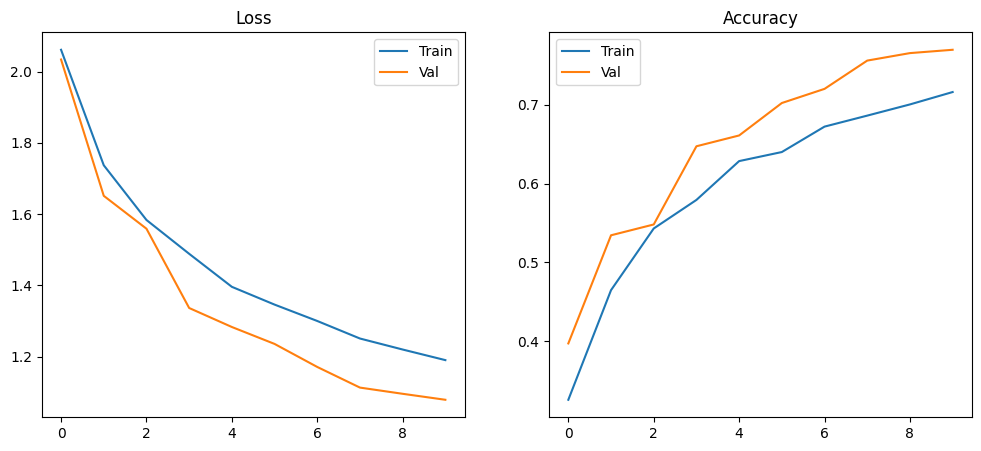

In [ ]:
resnet_model = resnet18v2(num_classes=10)
train(resnet_model, train_loader, val_loader, device, num_epochs=NUM_EPOCHS)

In [ ]:
class BasicBlockv3(nn.Module):
    expansion = 1  # Output channels multiplier

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.downsample = downsample
        # ---- YOUR CODE STARTS HERE ----------
        self.batch1 = nn.BatchNorm2d(planes)
        self.batch2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        # ---- YOUR CODE ENDS HERE ----------

    def forward(self, x):
        # ---- YOUR CODE STARTS HERE ----------
        #relu before rc
        #normal: conv -> bnorm -> relu -> conv -> bnorm -> rc -> relu
        #new:    conv -> bnorm -> relu -> conv -> bnorm -> relu -> rc
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batch2(out)
        out = self.relu(out)

        if self.downsample is not None:
            x = self.downsample(x)

        out = x + out
        # ---- YOUR CODE ENDS HERE ----------
        return out


def resnet18v3(num_classes=10):
    # ResNet-18 = [2, 2, 2, 2] blocks per layer
    return ResNet(BasicBlockv3, [2, 2, 2, 2], num_classes=num_classes)

 10%|█         | 1/10 [00:32<04:52, 32.53s/it]

Epoch 01/10 - Train loss: 1.8917, acc: 0.4005 | Val loss: 1.8076, acc: 0.4340


 20%|██        | 2/10 [01:04<04:16, 32.03s/it]

Epoch 02/10 - Train loss: 1.6240, acc: 0.5258 | Val loss: 1.7141, acc: 0.4805


 30%|███       | 3/10 [01:36<03:45, 32.15s/it]

Epoch 03/10 - Train loss: 1.4927, acc: 0.5877 | Val loss: 1.3714, acc: 0.6547


 40%|████      | 4/10 [02:08<03:11, 31.94s/it]

Epoch 04/10 - Train loss: 1.4144, acc: 0.6203 | Val loss: 1.2903, acc: 0.6800


 50%|█████     | 5/10 [02:40<02:40, 32.05s/it]

Epoch 05/10 - Train loss: 1.3412, acc: 0.6459 | Val loss: 1.4170, acc: 0.6357


 60%|██████    | 6/10 [03:11<02:07, 31.82s/it]

Epoch 06/10 - Train loss: 1.2828, acc: 0.6755 | Val loss: 1.1453, acc: 0.7371


 70%|███████   | 7/10 [03:44<01:36, 32.05s/it]

Epoch 07/10 - Train loss: 1.2219, acc: 0.7007 | Val loss: 1.1446, acc: 0.7360


 80%|████████  | 8/10 [04:15<01:03, 31.83s/it]

Epoch 08/10 - Train loss: 1.1852, acc: 0.7187 | Val loss: 1.0632, acc: 0.7814


 90%|█████████ | 9/10 [04:49<00:32, 32.35s/it]

Epoch 09/10 - Train loss: 1.1524, acc: 0.7359 | Val loss: 1.0653, acc: 0.7782


100%|██████████| 10/10 [05:20<00:00, 32.02s/it]

Epoch 10/10 - Train loss: 1.1380, acc: 0.7415 | Val loss: 1.0226, acc: 0.8089


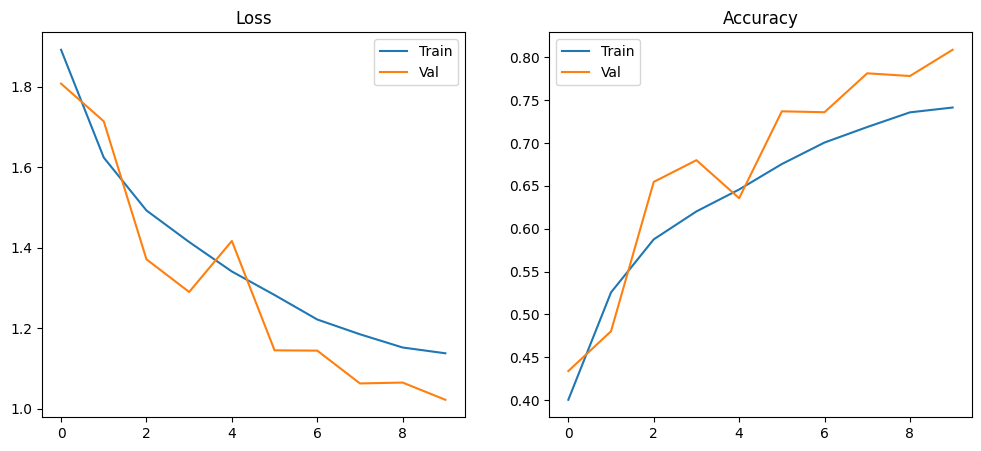

In [ ]:
resnet_model = resnet18v3(num_classes=10)
train(resnet_model, train_loader, val_loader, device, num_epochs=NUM_EPOCHS)

## 2. ViT (6 points)

### 2.a) ViT implementation

We have provided the skeleton of a Vision Transformer (ViT). The
classes are missing parts of the constructor and/or forward methods, which you must complete. Follow the original ViT paper architecture.

In [ ]:
import torch
import torch.nn as nn
import math

class PatchEmbed(nn.Module):
    """Divide image into patches, project to embedding."""
    def __init__(self, img_size=224, patch_size=32, in_chans=3, embed_dim=192):
        super().__init__()
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size * self.grid_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: [B, 3, H, W] -> [B, embed_dim, grid, grid] -> [B, num_patches, embed_dim]
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x  # [B, num_patches, embed_dim]

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, p=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        # ---- YOUR CODE STARTS HERE ----------
        #"The MLP contains two layers with a GELU non-linearity." p.4
        self.linear1 = nn.Linear(in_features, hidden_features)
        self.linear2 = nn.Linear(hidden_features, out_features)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(p)
        # ---- YOUR CODE ENDS HERE ----------

    def forward(self, x):
        # ---- YOUR CODE STARTS HERE ----------
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.gelu(x)
        x = self.dropout(x) #dropout_layer because we have an p?????
        # ---- YOUR CODE ENDS HERE ----------
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=3, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        # ---- YOUR CODE STARTS HERE ----------

        self.q_lin = nn.Linear(dim, dim, bias = qkv_bias)
        self.k_lin = nn.Linear(dim, dim, bias = qkv_bias)
        self.v_lin = nn.Linear(dim, dim, bias = qkv_bias)
        self.attn_drp = nn.Dropout(attn_drop)
        self.proj_lin = nn.Linear(dim, dim)
        self.proj_drp = nn.Dropout(proj_drop)

        # ---- YOUR CODE ENDS HERE ----------

    def forward(self, x):
        B, N, C = x.shape #batch,tokens,feature
        # ---- YOUR CODE STARTS HERE ----------

        q = self.q_lin(x)
        k = self.k_lin(x)
        v = self.v_lin(x)

        q = q.reshape(B, N, C // self.num_heads, self.num_heads) #[B,N,C,H]
        q = q.permute(0, 3, 1, 2)                                #[B,H,N,C] (Standard)
        k = k.reshape(B, N, C // self.num_heads, self.num_heads)
        k = k.permute(0, 3, 1, 2)
        v = v.reshape(B, N, C // self.num_heads, self.num_heads)
        v = v.permute(0, 3, 1, 2)



        attn = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(C // self.num_heads) #V2 S.63
        attn = torch.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)

        out = out.transpose(1, 2)   #[B,H,N,C] -> [B,N,H,C]
        out = out.reshape(B, N, C)  #[B,N,H,C] -> [B,N,C=HxC] (macht Reshape automatisch)
        out = self.proj_lin(out)
        out = self.proj_drp(out)

        # ---- YOUR CODE ENDS HERE ----------
        return out

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.attn = Attention(dim, num_heads, qkv_bias, attn_drop=attn_p, proj_drop=p)
        self.mlp = MLP(dim, int(dim*mlp_ratio), p=p)
        # ---- YOUR CODE STARTS HERE ----------
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        # ---- YOUR CODE ENDS HERE ----------

    def forward(self, x):
        # ---- YOUR CODE STARTS HERE ----------
        #The Transformer encoder consists of alternating layers of multiheaded self-attention and MLP blocks
        # Layernorm is applied before every block, and residual connections after every block. S.3
        x = x + self.attn(self.norm1(x)) #1.norm 2.attn 3.RC

        x = x + self.mlp(self.norm2(x))
        # ---- YOUR CODE ENDS HERE ----------
        return x

class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=32, in_chans=3, num_classes=10,
                 embed_dim=128,
                 depth=12,
                 num_heads=4,
                 mlp_ratio=4., qkv_bias=True, p=0., attn_p=0., block=Block):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.Sequential(*[
            block(embed_dim, num_heads, mlp_ratio, qkv_bias, p=p, attn_p=attn_p)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        # ---- YOUR CODE STARTS HERE ----------
        #1.Patches
        #2.Patch + Postition Embedding
        #(Dropout)
        #3. Transformer-Encoder
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        x = self.blocks(x)
        x = self.norm(x) #Steht nicht im Paper, oder? self.norm existiert aber

        # ---- YOUR CODE ENDS HERE ----------
        pooled = x.mean(dim=1)  # [B, embed_dim]
        return self.head(pooled)

### 2.b) Train and evaluate the ViT

Use the same training and evaluation functions. Train and validate your ViT.

Number of parameters in your ViT: 2,780,426


 10%|█         | 1/10 [00:31<04:43, 31.55s/it]

Epoch 01/10 - Train loss: 2.1732, acc: 0.2424 | Val loss: 2.0897, acc: 0.2841


 20%|██        | 2/10 [01:02<04:09, 31.24s/it]

Epoch 02/10 - Train loss: 2.0727, acc: 0.2968 | Val loss: 2.0288, acc: 0.3052


 30%|███       | 3/10 [01:32<03:35, 30.81s/it]

Epoch 03/10 - Train loss: 2.0073, acc: 0.3263 | Val loss: 1.9547, acc: 0.3358


 40%|████      | 4/10 [02:04<03:06, 31.09s/it]

Epoch 04/10 - Train loss: 1.9220, acc: 0.3703 | Val loss: 1.8709, acc: 0.3928


 50%|█████     | 5/10 [02:34<02:34, 30.91s/it]

Epoch 05/10 - Train loss: 1.8438, acc: 0.4035 | Val loss: 1.7658, acc: 0.4530


 60%|██████    | 6/10 [03:05<02:02, 30.73s/it]

Epoch 06/10 - Train loss: 1.7643, acc: 0.4438 | Val loss: 1.7116, acc: 0.4815


 70%|███████   | 7/10 [03:36<01:32, 30.88s/it]

Epoch 07/10 - Train loss: 1.7258, acc: 0.4683 | Val loss: 1.6918, acc: 0.4794


 80%|████████  | 8/10 [04:06<01:01, 30.63s/it]

Epoch 08/10 - Train loss: 1.6978, acc: 0.4805 | Val loss: 1.6455, acc: 0.5069


 90%|█████████ | 9/10 [04:37<00:30, 30.69s/it]

Epoch 09/10 - Train loss: 1.6505, acc: 0.5031 | Val loss: 1.6209, acc: 0.5143


100%|██████████| 10/10 [05:08<00:00, 30.81s/it]

Epoch 10/10 - Train loss: 1.6401, acc: 0.5075 | Val loss: 1.6160, acc: 0.5153


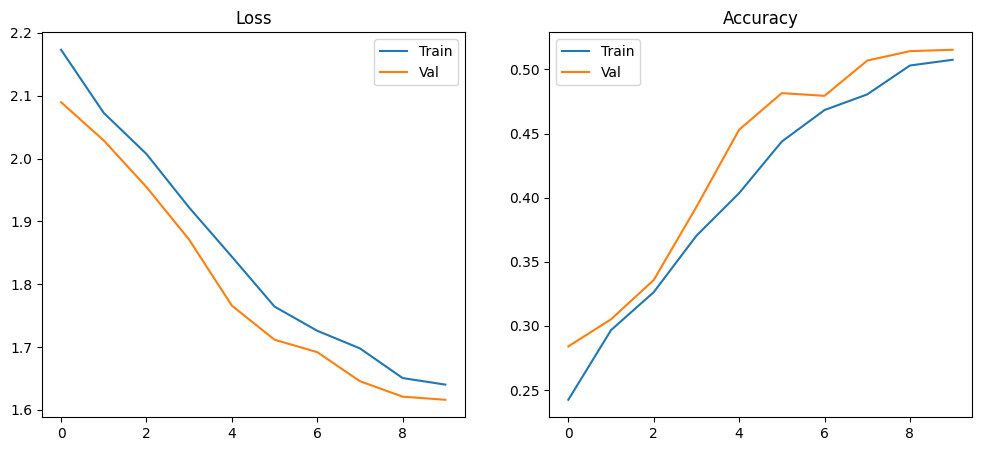

In [ ]:
vit_model = ViT(num_classes=len(train_loader.dataset.dataset.classes)).to(device)
print(f"Number of parameters in your ViT: {count_parameters(vit_model):,}")

train(vit_model, train_loader, val_loader, device, num_epochs = NUM_EPOCHS)

### 2.d) Experiment with the order of operations in ViT Block

We instantiate two new blocks, `Blockv2`
and `Blockv3`.

Complete the **\_\_init\_\_()** and **forward()** methods of each of the two classes. In each case, the
implementation should be distinct, by modifying the order of operations in the original `Block`.

Train and evaluate these models with the existing code.

In [ ]:
class Blockv2(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.attn = Attention(dim, num_heads, qkv_bias, attn_drop=attn_p, proj_drop=p)
        self.mlp = MLP(dim, int(dim*mlp_ratio), p=p)
        # ---- YOUR CODE STARTS HERE ----------
        # This can't add any new element besides those used in Block
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        # ---- YOUR CODE END HERE ----------

    def forward(self, x):
        # ---- YOUR CODE STARTS HERE ----------#
        # post norm

        x = self.norm1(x + self.attn(x))

        x = self.norm2(x + self.mlp(x))

        # ---- YOUR CODE ENDS HERE ----------
        return x

vit_model = ViT(num_classes=len(train_loader.dataset.dataset.classes), block=Blockv2).to(device)
print(f"Number of parameters in your ViT: {count_parameters(vit_model):,}")

train(vit_model, train_loader, val_loader, device, num_epochs = NUM_EPOCHS)

Number of parameters in your ViT: 2,774,282


  0%|          | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
class Blockv3(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.attn = Attention(dim, num_heads, qkv_bias, attn_drop=attn_p, proj_drop=p)
        self.mlp = MLP(dim, int(dim*mlp_ratio), p=p)
        # ---- YOUR CODE STARTS HERE ----------
        # This can't add any new element besides those used in Block
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        # ---- YOUR CODE END HERE ----------

    def forward(self, x):
        # ---- YOUR CODE STARTS HERE ----------
        a = self.attn(self.norm1(x))
        b = self.mlp(self.norm2(x))
        x = x + a + b
        # ---- YOUR CODE ENDS HERE ----------
        return x

vit_model = ViT(num_classes=len(train_loader.dataset.dataset.classes), block=Blockv3).to(device)
print(f"Number of parameters in your ViT: {count_parameters(vit_model):,}")

train(vit_model, train_loader, val_loader, device, num_epochs = NUM_EPOCHS)

## 3. ViT enhancements (4 Pts.)

### 3.b) Experiment!

Change one or more hyperparameters to improve the validation accuracy using the same number of training samples.

 10%|█         | 1/10 [00:31<04:39, 31.01s/it]

Epoch 01/10 - Train loss: 2.1843, acc: 0.2337 | Val loss: 2.1056, acc: 0.2661


 20%|██        | 2/10 [01:03<04:13, 31.64s/it]

Epoch 02/10 - Train loss: 2.0864, acc: 0.2817 | Val loss: 2.0518, acc: 0.3126


 30%|███       | 3/10 [01:34<03:39, 31.31s/it]

Epoch 03/10 - Train loss: 2.0262, acc: 0.3252 | Val loss: 1.9795, acc: 0.3580


 40%|████      | 4/10 [02:05<03:08, 31.39s/it]

Epoch 04/10 - Train loss: 1.9451, acc: 0.3575 | Val loss: 1.8917, acc: 0.3759


 50%|█████     | 5/10 [02:36<02:36, 31.24s/it]

Epoch 05/10 - Train loss: 1.8741, acc: 0.3923 | Val loss: 1.8251, acc: 0.4329


 60%|██████    | 6/10 [03:08<02:05, 31.47s/it]

Epoch 06/10 - Train loss: 1.8018, acc: 0.4311 | Val loss: 1.7474, acc: 0.4657


 70%|███████   | 7/10 [03:39<01:33, 31.23s/it]

Epoch 07/10 - Train loss: 1.7414, acc: 0.4519 | Val loss: 1.7093, acc: 0.4910


 80%|████████  | 8/10 [04:11<01:02, 31.47s/it]

Epoch 08/10 - Train loss: 1.6952, acc: 0.4808 | Val loss: 1.6852, acc: 0.4879


 90%|█████████ | 9/10 [04:43<00:31, 31.90s/it]

Epoch 09/10 - Train loss: 1.6704, acc: 0.4939 | Val loss: 1.6315, acc: 0.5048


100%|██████████| 10/10 [05:15<00:00, 31.57s/it]

Epoch 10/10 - Train loss: 1.6471, acc: 0.5001 | Val loss: 1.6355, acc: 0.5143


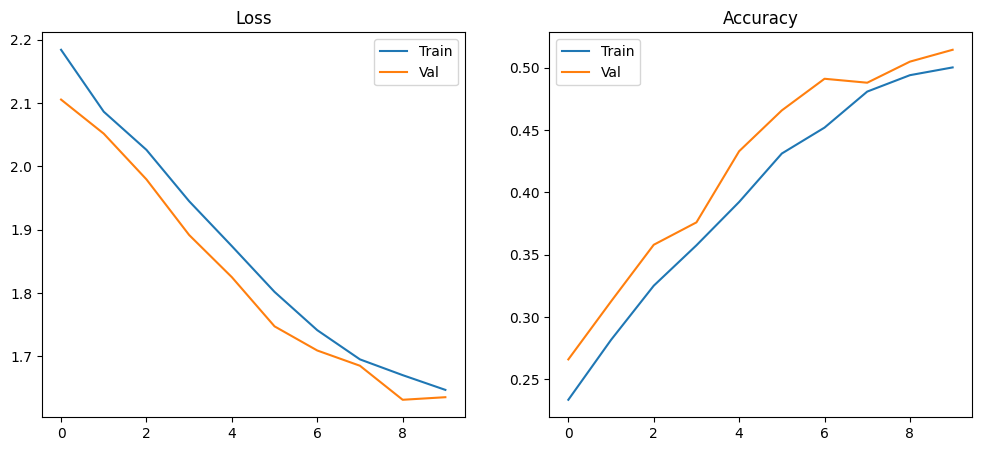

In [ ]:
# ---- YOUR CODE STARTS HERE --------

vit_model = ViT(
    #p = 0.2, attn_p = 0.2,  #0.0 -> 0.2
    #patch_size = 16,        #32 -> 16
    #embed_dim = 180,        #128 -> 180
    #depth = 24,             #12 -> 24
    num_heads = 8,          #4 -> 8
    num_classes=len(train_loader.dataset.dataset.classes)).to(device)

# ---- YOUR CODE ENDS HERE ----------

train(vit_model, train_loader, val_loader, device, num_epochs=NUM_EPOCHS)